# LSTM Implementation From Scratch using pytorch

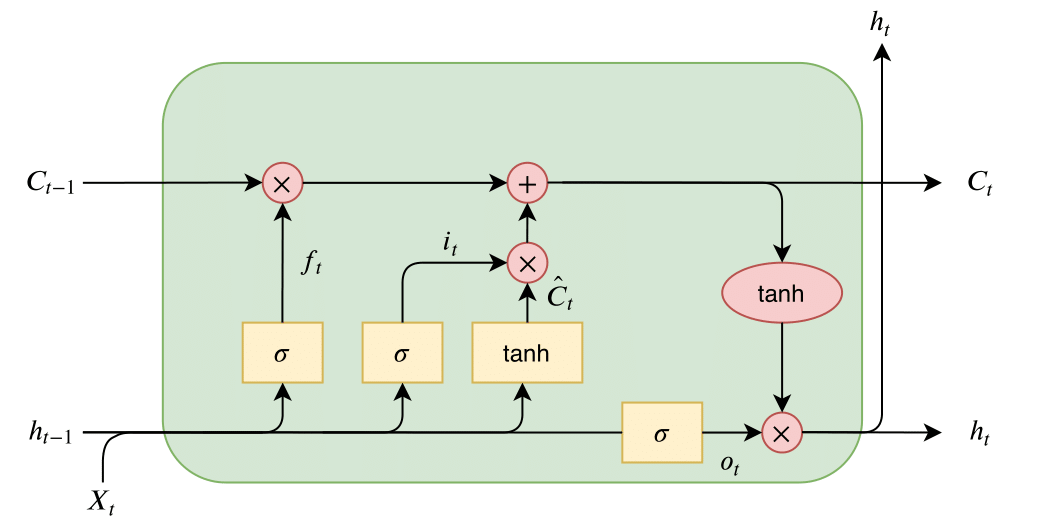

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class LSTMcell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMcell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # weights for forget gate
        self.W_f = nn.Parameter(torch.randn(self.input_size+self.hidden_size, self.hidden_size))
        self.b_f = nn.Parameter(torch.zeros(self.hidden_size))

        # weigths for input gate
        self.W_i = nn.Parameter(torch.randn(self.input_size+self.hidden_size, self.hidden_size))
        self.b_i = nn.Parameter(torch.zeros(self.hidden_size))

        # weights for candidate gate
        self.W_c = nn.Parameter(torch.randn(self.input_size+self.hidden_size, self.hidden_size))
        self.b_c = nn.Parameter(torch.zeros(self.hidden_size))

        # weights for output gate
        self.W_o = nn.Parameter(torch.randn(self.input_size+self.hidden_size, self.hidden_size))
        self.b_o = nn.Parameter(torch.zeros(self.hidden_size))

    def forward(self, x, h_prev, c_prev):
        # x -> (batch_size, embd_size)
        # h_prev -> (batch_size, vector_size)
        # c_prev -> (batch_size, vector_size)

        x_h_prev = torch.cat((x, h_prev), dim=1)
        # --- forget gate ------------------------
        # compute ft
        ft = torch.sigmoid(
            x_h_prev @ self.W_f + self.b_f
        )

        c_state = c_prev * ft
        # ------ input gate ----------------------
        it = torch.sigmoid(
            x_h_prev @ self.W_i + self.b_i
        )
    
        ct_cap = torch.tanh(
            x_h_prev @ self.W_c + self.b_c
        )
        c_state = c_state + it * ct_cap 
        #--------output_gate --------------------
        ot = torch.sigmoid(
            x_h_prev @ self.W_o + self.b_o
        )
        h_state = torch.tanh(c_state) * ot

        return c_state, h_state

In [10]:
batch_size = 2
input_size = 6
hidden_size = 2

x = torch.randn((batch_size, input_size))
h_prev = torch.randn((batch_size, hidden_size))
c_prev = torch.randn((batch_size, hidden_size))

lstm_cell = LSTMcell(input_size, hidden_size)
c_state, h_state = lstm_cell(x, h_prev, c_prev)
print("cell_state shape: ", c_state.shape)
print("h_state shape: ", h_state.shape)

cell_state shape:  torch.Size([2, 2])
h_state shape:  torch.Size([2, 2])


In [11]:
print("h_prev: ", h_prev)
print("h_state: ", h_state)

print("c_prev: ", c_prev)
print("c_state: ", c_state)

h_prev:  tensor([[ 0.3211,  0.1503],
        [-0.2188, -0.0226]])
h_state:  tensor([[-0.4182,  0.1537],
        [ 0.1163, -0.0696]], grad_fn=<MulBackward0>)
c_prev:  tensor([[-0.6561,  0.7958],
        [-0.1370,  0.3144]])
c_state:  tensor([[-0.5616,  0.4911],
        [ 0.1170, -0.1463]], grad_fn=<AddBackward0>)


In [23]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm_cell = LSTMcell(self.input_size, self.hidden_size)

    def forward(self, input_seq):
        # input_seq -> (batch_size, seq_length, input_size)
        self.batch_size = input_seq.size(0)
        self.seq_length = input_seq.size(1)

        h_prev = torch.zeros((self.batch_size, self.hidden_size)).to(input_seq.device)
        c_prev = torch.zeros((self.batch_size, self.hidden_size)).to(input_seq.device)

        outputs = []
        for t_step in range(self.seq_length):
            x = input_seq[:, t_step, :]
            h_prev, c_prev = self.lstm_cell(x, h_prev, c_prev)
            outputs.append(h_prev.unsqueeze(1))

        # all hidden states and last hidden and cell state
        return torch.cat(outputs, axis=1), h_prev, c_prev

In [24]:
batch_size = 2
seq_len = 2
input_size = 6

x = torch.randn((batch_size, seq_len, input_size))

lstm = SimpleLSTM(input_size, hidden_size)
whole_seq_output, final_hidden_state, final_cell_state = lstm(x)

In [26]:
print("whole seq_output size", whole_seq_output.shape)
print("whole seq_output", whole_seq_output)

whole seq_output size torch.Size([2, 2, 2])
whole seq_output tensor([[[ 0.4609,  0.4845],
         [ 0.1625,  0.8757]],

        [[-0.9921, -0.0113],
         [ 0.5260, -0.2163]]], grad_fn=<CatBackward0>)


In [27]:
print("final hidden state: ", final_hidden_state.shape)
print("final cell state: ", final_cell_state.shape)

final hidden state:  torch.Size([2, 2])
final cell state:  torch.Size([2, 2])


# BiDirectional LSTM

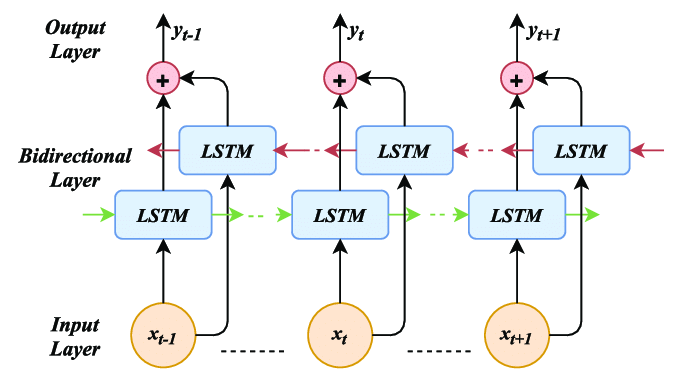

In [40]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BidirectionalLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.forward_lstm_cell = LSTMcell(self.input_size, self.hidden_size)
        self.backward_lstm_cell = LSTMcell(self.input_size, self.hidden_size)

    def forward(self, input_seq):
        # input_seq -> (batch_size, seq_length, input_size)
        self.batch_size = input_seq.size(0)
        self.seq_length = input_seq.size(1)

        # ------forward layer ---------------------------
        h_f = torch.zeros((self.batch_size, self.hidden_size)).to(input_seq.device)
        c_f = torch.zeros((self.batch_size, self.hidden_size)).to(input_seq.device)
        forward_outputs = []
        for t_step in range(self.seq_length):
            x = input_seq[:, t_step, :]
            h_f, c_f = self.forward_lstm_cell(x, h_f, c_f)
            forward_outputs.append(h_f.unsqueeze(1))

        forward_outputs = torch.cat(forward_outputs, axis=1) # batch_size x seq_len X hidden_size
        
        # ----- backward layer -------------------------
        h_b = torch.zeros((self.batch_size, self.hidden_size)).to(input_seq.device)
        c_b = torch.zeros((self.batch_size, self.hidden_size)).to(input_seq.device)
        backward_outputs = []
        for t_step in range(self.seq_length-1, -1, -1):
            x = input_seq[:, t_step, :]
            h_b, c_b = self.backward_lstm_cell(x, h_b, c_b)
            backward_outputs.append(h_prev.unsqueeze(1))
            
        backward_outputs.reverse()
        backward_outputs = torch.cat(backward_outputs, axis=1) # batch_size x seq_len x hidden_size
        
        # merge forward and backward output
        outputs = torch.cat([forward_outputs, backward_outputs], dim=2) # batch_size x seq_len x 2*hidden_size
        
        # all hidden states and last hidden and cell state
        return outputs, outputs[-1], torch.cat([c_f, c_b], dim=1)

In [41]:
batch_size = 2
seq_len = 2
input_size = 6

x = torch.randn((batch_size, seq_len, input_size))

lstm = BidirectionalLSTM(input_size, hidden_size)
whole_seq_output, final_hidden_state, final_cell_state = lstm(x)

In [42]:
print("whole seq_output size", whole_seq_output.shape)
print("final hidden state: ", final_hidden_state.shape)
print("final cell state: ", final_cell_state.shape)

whole seq_output size torch.Size([2, 2, 4])
final hidden state:  torch.Size([2, 4])
final cell state:  torch.Size([2, 4])


# DeepLSTM

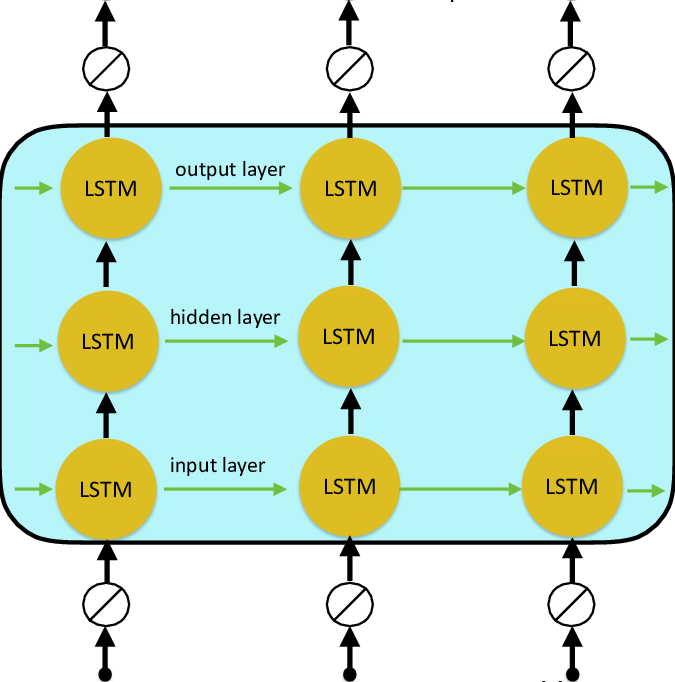

In [44]:
class DeepLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(DeepLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm_cells = nn.ModuleList()
        for layer_idx in range(self.num_layers):
            input_size = self.input_size if layer_idx == 0 else self.hidden_size 
            self.lstm_cells.append(LSTMcell(input_size, self.hidden_size))

    def forward(self, input_seq):
        # input_seq -> batch_size, seq_length , input_size
        self.batch_size = input_seq.size(0)
        self.seq_length = input_seq.size(1)

        h_prev = [torch.zeros(self.batch_size, self.hidden_size)
                  for _ in range(self.seq_length)]
        c_prev = [torch.zeros(self.batch_size, self.hidden_size)
                  for _ in range(self.seq_length)]

        outputs = []
        for seq_idx in range(self.seq_length):
            x = input_seq[:, seq_idx, :]
            for layer_idx in range(self.num_layers):
                h = h_prev[layer_idx]
                c = c_prev[layer_idx]
                h_new , c_new = self.lstm_cells[layer_idx](x, h, c)
                h_prev[layer_idx] = h_new
                c_prev[layer_idx] = c_new
                x = h_new
            outputs.append(h_new.unsqueeze(1))

        return torch.cat(outputs, axis=1)

In [49]:
batch_size = 2
seq_len = 2
input_size = 6

x = torch.randn((batch_size, seq_len, input_size))

lstm = DeepLSTM(input_size, hidden_size)
whole_seq_output = lstm(x)

In [50]:
print("whole seq_output size", whole_seq_output.shape)

whole seq_output size torch.Size([2, 2, 2])
